# Drying Time and Product Temperature Calculations

In [3]:
#Outputs: 
    #Drying Time Calculations
    #Product Temperature Calculations
    #Least squares Fitting of Tproduct based on Kv values and Resistance fitting(Equation 3)

In [48]:
#Libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import math

## Resistance Parameters from Resistance Fitting Model

Parameters for 2NN : [-8.85164801e-02  9.04999955e+04  6.50812284e+00]

Parameters for 3NN : [2.18050145e+02 1.50001103e+05 1.56730158e+01]

Parameters for 4NN : [1.79561470e-01 1.20100004e+05 1.07020467e+01]

Parameters for core : [-4.42872347e+02  1.20078699e+05  2.31393004e+01]

## Product Temperature

### Load Excel Sheet

In [49]:
#Initial Data(SV File)
file_location = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\GS0132_F2_LL_SV_hrs.xlsx'
assert os.path.isfile(file_location)
df = pd.read_excel(file_location,sheet_name='GS0132_F2_LL_SV_hrs')
print(list(df.columns))

['Timestamp', ' SPLYO.CONDENSER_TEMPERATURE.F_CV', ' SPLYO.SHELF_OUTLET.F_CV', ' SPLYO.SHELF_INLET.F_CV', ' SPLYO.SHELF_SP.F_CV', ' SPLYO.TC_AVG.F_CV', ' SPLYO.VACUUM_SP.F_CV', ' SPLYO.CHAMBER_CM.F_CV', ' SPLYO.ROUGH_VACUUM.F_CV', ' SPLYO.CHAMBER_PIRANI.F_CV', ' SPLYO.CONDENSER_VACUUM.F_CV']


In [50]:
# Load Data(PP File)
file_location2 = r'C:\Users\sbadih\OneDrive - Gilead Sciences\Trodelvy 2.0 Modelling Data\GS-0132_F2_LL_PP_hrs.xlsx'
assert os.path.isfile(file_location2)
df2 = pd.read_excel(file_location2,sheet_name='GS-0132_F2_LL_PP_hrs')
print("Headers:")
print(list(df2.columns))

Headers:
['Timestamp', ' SPLYO.TC01.F_CV', ' SPLYO.TC02.F_CV', ' SPLYO.TC03.F_CV', ' SPLYO.TC04.F_CV', ' SPLYO.TC05.F_CV', ' SPLYO.TC06.F_CV', ' SPLYO.TC07.F_CV', ' SPLYO.TC08.F_CV', ' SPLYO.TC09.F_CV', ' SPLYO.TC10.F_CV', ' SPLYO.TC11.F_CV', ' SPLYO.TC12.F_CV', ' SPLYO.TC13.F_CV', ' SPLYO.TC14.F_CV', ' SPLYO.TC15.F_CV', ' SPLYO.TC16.F_CV', ' SPLYO.TC_AVG.F_CV']


### Load Parameters

In [11]:
#Function to Calc. Sublimation Pressure
def sub_p(T): #input is temperature
    sp=(np.exp(24.01849-6144.96/((T)+273)))*1000
    return sp

In [12]:
#Extract required variables to find the start and stop index
cham_pres=((df[[' SPLYO.CHAMBER_CM.F_CV']]).values)
pirani_pres=(df[[' SPLYO.CHAMBER_PIRANI.F_CV']].values)
#Find Nested Configuration Temperatures
T_2N=(df2[[' SPLYO.TC06.F_CV']]).values
T_3N=(df2[[' SPLYO.TC03.F_CV']]).values
T_4N=(df2[[' SPLYO.TC01.F_CV']]).values
sub_pres2=sub_p(T_2N)
sub_pres3=sub_p(T_3N)
sub_pres4=sub_p(T_4N)

In [13]:
#Find Index Information(Same as Resistance Sheet)
# 2NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres2[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres2[i])
minimum=np.array(minimum) #convert list to array
min_ind2=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind2=ind[min_ind2] #Find the index in the sublimation pressure where the minimum occurs
# 3NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres3[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres3[i])
minimum=np.array(minimum) #convert list to array
min_ind3=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind3=ind[min_ind3] #Find the index in the sublimation pressure where the minimum occurs

# 4NN
minimum=[]
ind=[]
for i in range(len(cham_pres)):
    if sub_pres4[i]<98.5:
        ind.append(i)
        minimum.append(cham_pres[i]-sub_pres4[i])
minimum=np.array(minimum) #convert list to array
min_ind4=np.argmin(minimum) #Find the index in the minimum array where the minimum difference occurs
strt_ind4=ind[min_ind4] #Find the index in the sublimation pressure where the minimum occurs

print("Start Index for 2NN:",strt_ind2)
print("Start Index for 3NN:",strt_ind3)
print("Start Index for 4NN:",strt_ind4)

#Stop Index
index=[]
diff=[]
for i in range(len(pirani_pres[strt_ind2:])): #start where the primary drying starts
    if pirani_pres[strt_ind2+i]<80:
        index.append(i+strt_ind2)
   #Stop Index is the same for all vial configurations 
stop_ind=index[0] #pick the timestamp where the pirani goes close to 75. This only applies to LL cycle

tol=1E-10
if abs(strt_ind2-strt_ind3)<tol and abs(strt_ind3-strt_ind4)<tol and abs(strt_ind2-strt_ind4)<tol:
    strt_ind=strt_ind2
    print("Strt Index:",strt_ind)
# stop_ind=67
print("Stop Index is:",stop_ind)

Start Index for 2NN: 18
Start Index for 3NN: 18
Start Index for 4NN: 18
Strt Index: 18
Stop Index is: 68


In [14]:
#Elapsed Time Array
time=(df[['Timestamp']]).values #every hour
cycle_time=(np.arange(0,len(time),1))[strt_ind:stop_ind] #Create array for time passed in increments of 1 hour

#Pirani Pressure
pirani_pres=((df[[' SPLYO.CHAMBER_PIRANI.F_CV']]).values)[strt_ind:stop_ind]

#Chamber Pressure
cham_pres=(((df[[' SPLYO.CHAMBER_CM.F_CV']]).values)/1000)[strt_ind:stop_ind] #This is the capacitance monometer reading(Torr)

shelf_temp=((df[[' SPLYO.SHELF_SP.F_CV']]).values)[strt_ind:stop_ind] ##Check which one this should be?
shelf_temp=shelf_temp.reshape(-1)

## Inputs

In [17]:
#Input Parameters
SAin = float(input("Enter Surface Area In(cm^2): ")) #5.982843996
print(SAin)
vial_capac = float(input("Enter Vial Capac: ")) #20
print(vial_capac)
Din = float(input("Enter Diameter In (cm): ")) #2.76
print(Din)
Dout = float(input("Enter Diameter Out (cm): ")) #3
print(Dout)
ice_den = float(input("Enter Ice Density: ")) #0.918
print(ice_den)
den = float(input("Enter Density: ")) #1.036
print(den)
fill_vol = float(input("Enter Fill Volume(ml): ")) #6.3
print(fill_vol)
water_cont = float(input("Enter Water Content: ")) #0.484
print(water_cont)
vial_numbers = float(input("Enter Vial Numbers(filled): ")) #86
print(vial_numbers)
T_critical = float(input("Enter Collapse Temperature(C): ")) #-21.2
print(T_critical)
dry_cake=(fill_vol*den)/(SAin*ice_den)
print("Dry Cake Initial Height:",dry_cake)
lam=0.00358

Enter Surface Area In(cm^2): 5.982843996
5.982843996
Enter Vial Capac: 20
20.0
Enter Diameter In (cm): 2.76
2.76
Enter Diameter Out (cm): 3
3.0
Enter Ice Density: 0.918
0.918
Enter Density: 1.036
1.036
Enter Fill Volume(ml): 6.3
6.3
Enter Water Content: 0.484
0.484
Enter Vial Numbers(filled): 86
86.0
Enter Collapse Temperature(C): -21.2
-21.2
Dry Cake Initial Height: 1.1883652534350033


## Kv and Resistance 

In [51]:
#Store resistance parameters
    #Note this is extracted from the resistance calculation sheets(Tchessalov Model)
a = float(input("Enter your A parameter for resistance: ")) #-8.85164801e-02
print(a)
b = float(input("Enter your B parameter for resistance: ")) #9.04999955e+04
print(b)
c = float(input("Enter your C parameter for resistance: ")) #6.50812284e+00
print(c)

cake_res_param=np.zeros(3)
cake_res_param[0]=a
cake_res_param[1]=b
cake_res_param[2]=c
#cake_res_param=np.array(([-8.85164801e-02,9.04999955e+04,6.50812284e+00],[2.18050145e+02,1.50001103e+05,1.56730158e+01],[1.79561470e-01,1.20100004e+05,1.07020467e+01],[-4.42872347e+02,1.20078699e+05,2.31393004e+01]))

value = float(input("Enter your Kv value: ")) #0.00020961432864185497
print(value)
Kv_values=np.repeat(value,len(pirani_pres)) #From Kv Fitting model, doesn't change based on vial configuration
print("Kv Values Shape:",Kv_values.shape)


Enter your A parameter for resistance: -8.85164801e-02
-0.0885164801
Enter your B parameter for resistance: 9.04999955e+04
90499.9955
Enter your C parameter for resistance: 6.50812284e+00
6.50812284
Enter your Kv value: 0.00020961432864185497
0.00020961432864185497
Kv Values Shape: (50,)


Note: For each cycle we run will have 3 different values of resistance and only one value for Kv(based on assumption that nearest neighbours configuration doesn't effect the Kv value).

### Heat Flux

$$hf=(ShelfTemp-Tproduct))*Kv$$

### Sublimation Heat

$$sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycleTime[i]-cycleTime[i-1])*\frac{3600}{2}*Dout*\frac{pi}{4}$$

### Mass of Sublimed Ice

$$msi=\frac{sh}{676}$$

### Product Dried Layer

$$pdl=\frac{msi}{waterCont*iceDen*Din^2*\frac{pi}{4}}$$

### Cake Resistance

$$cakeRes=A+\frac{(B*pdl)}{(1+C*pdl)}$$

### Ice Surface Temperature

$$TempIceSurf=Tproduct-hf*\frac{dryCake-pdl}{lambda}$$

### Theoretical Pressure

$$presPred=e^\frac{24.01849-6144.96}{(Tice_surf+273)}$$

### Experimental Pressure

$$pReal=chamPres+cakeRes*3600*(\frac{Dout^2}{Din^2})*Kv*\frac{shelfTemp-Tproduct}{676}$$

### Iterative OLS approach to fit the product temperature(T_p) by backtracking from pressure calculations

In [52]:
#OLS Function
def ols_fit():
    #Define Parameter Set(Initial)
    T_p_0=(df2[[' SPLYO.TC_AVG.F_CV']]).values #Used thermocouple average as a starting point for the product temperature fitting
    T_p_0=(T_p_0.reshape(-1))[strt_ind:stop_ind]
    
    #Define Residuals Function
    def residuals(T_p): #T_p is the parameter we are fitting
        #Need to calculate initial condition for cake resistance and Tice based on initial T_p_0 guess
        #Go through all steps here
        #Define function to calculate cake resistance and Tice
        def intermed(T_p):
            hf=(shelf_temp-T_p)*Kv_values
            sh=np.zeros(hf.size)
            for i in range(len(hf)):
                if i==0:
                    sh[i]=0
                else:
                    sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
            msi=sh/676
            pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
            cake_res=(cake_res_param[0]+((cake_res_param[1]*pdl)/(1+cake_res_param[2]*pdl)))/1000
            Tice_surf=T_p-hf*(dry_cake-pdl)/lam
            return cake_res, Tice_surf
        outputs=intermed(T_p) #variable to store cake res and Tice_surf
        p_pred=np.exp(24.01849-6144.96/(outputs[1].astype("float64")+273.0)) #Have to set initial condition for Tice_surf
        #p_pred=np.exp(24.01849-6144.96/(outputs[0]+273.0)) #Have to set initial condition for Tice_surf
        p_real=cham_pres.reshape(-1)+outputs[0]*3600*((Dout*Dout)/(Din*Din))*Kv_values*(shelf_temp-T_p)/676 #Have to set initial condition for cake_res
        p_real=np.array(p_real, dtype=float)
        res=p_pred-p_real
        return res
    #Least Squares Fitting
    lsq=least_squares(residuals,T_p_0, loss='soft_l1', f_scale=0.1)
    
    #Fitted Product Temperature
    T_p_fit=lsq.x
    
    return T_p_fit #final outcome T_p 

Fitted Temperature from OLS:
 [-35.69254266 -27.14894919 -25.17457502 -24.32181388 -23.78499223
 -23.47286217 -23.17354367 -23.04660441 -22.91890241 -22.82153447
 -22.76663315 -22.70839846 -22.60448267 -22.59028238 -22.60377397
 -22.54663154 -22.55346019 -22.54599351 -22.56188123 -22.52436217
 -22.52816672 -22.55366755 -22.58161409 -22.57410411 -22.56868594
 -22.58385064 -22.61935519 -22.65635118 -22.63868966 -22.65963184
 -22.71901777 -22.70500368 -22.72923272 -22.754419   -22.79908978
 -22.8446505  -22.853857   -22.90099507 -22.93031045 -22.96033557
 -22.99104255 -23.0224065  -23.05440513 -23.06842658 -23.12019435
 -23.15398493 -23.18834215 -23.22325326 -23.2587069  -23.29469294]


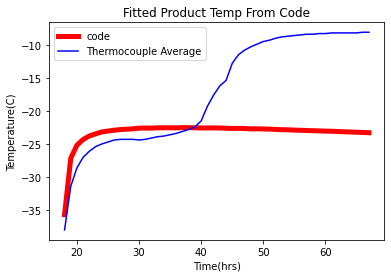

In [53]:
print("Fitted Temperature from OLS:\n",ols_fit()+5)
plt.plot(cycle_time,ols_fit()+5,color="red",linewidth=5,label="code")
plt.plot(cycle_time,(df2[[' SPLYO.TC_AVG.F_CV']]).values[strt_ind:stop_ind]+5,color="blue",label="Thermocouple Average")
plt.xlabel("Time(hrs)")
plt.ylabel("Temperature(C)")
plt.title("Fitted Product Temp From Code")
plt.legend()

Note: We will manually add 5 degrees to accommodate for the error in thermocouple calibration. 

In [54]:
#Function to calculate all intermediate values used to fit the T_product
def param(T_p):
    hf=(shelf_temp-T_p)*Kv_values
    sh=np.zeros(hf.size)
    for i in range(len(hf)):
        if i==0:
            sh[i]=0
        else:
            sh[i]=sh[i-1]+(hf[i]+hf[i-1])*(cycle_time[i]-cycle_time[i-1])*3600/2*Dout*Dout*np.pi/4
    msi=sh/676
    pdl=msi/(water_cont*ice_den*Din*Din*np.pi/4)
    cake_res=(cake_res_param[0]+((cake_res_param[1]*pdl)/(1+cake_res_param[2]*pdl)))/1000 #Want cake resistance in Torr
    Tice_surf=T_p-hf*(dry_cake-pdl)/lam
    return cake_res, Tice_surf, hf, msi, sh, pdl

In [55]:
#Calculate all outputs of our model using the fitted Tproduct 

#T product
T_p_model=ols_fit()+5
#Heat Flux
hf_model=param(ols_fit()+5)[2]
#Sublimation Heat
sh_model=param(ols_fit()+5)[4]
#Mass of Sublimed Ice 
msi_model=param(ols_fit()+5)[3]
#Product Dried Layer
pdl_model=param(ols_fit()+5)[5]
#Cake Resistance
cake_res_model=param(ols_fit()+5)[0]
#Tice_surf
Tice_model=param(ols_fit()+5)[1]
#Pressure(Experimental)
p_exp_model=cham_pres.reshape(-1)+(param(ols_fit()+5))[0]*3600*((Dout*Dout)/(Din*Din))*Kv_values*(shelf_temp-ols_fit()+5)/676
#Pressure(Theoretical)
p_theo_model=np.exp(24.01849-6144.96/((param(ols_fit()+5))[1].astype("float64")+273))

In [56]:
print(param(ols_fit()+5)[0])

[-8.85164801e-05  3.27077828e+00  5.32067645e+00  6.60484036e+00
  7.51564394e+00  8.20530307e+00  8.74932888e+00  9.19199089e+00
  9.56132204e+00  9.87444248e+00  1.01439643e+01  1.03787273e+01
  1.05846670e+01  1.07670754e+01  1.09304845e+01  1.10774774e+01
  1.12103751e+01  1.13313405e+01  1.14419496e+01  1.15433613e+01
  1.16366337e+01  1.17229173e+01  1.18030431e+01  1.18775528e+01
  1.19469279e+01  1.20117379e+01  1.20725147e+01  1.21296708e+01
  1.21834102e+01  1.22339993e+01  1.22818482e+01  1.23271126e+01
  1.23699385e+01  1.24105788e+01  1.24492264e+01  1.24860525e+01
  1.25211352e+01  1.25545970e+01  1.25865719e+01  1.26171367e+01
  1.26463840e+01  1.26743984e+01  1.27012572e+01  1.27270136e+01
  1.27517523e+01  1.27755496e+01  1.27984433e+01  1.28204844e+01
  1.28417204e+01  1.28621952e+01]


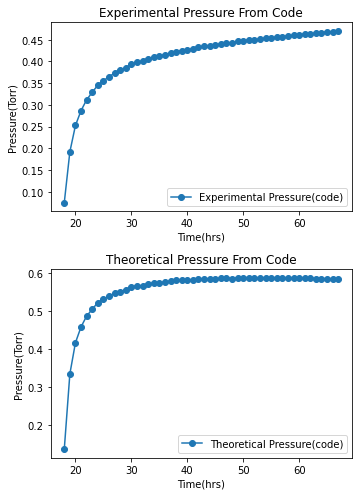

In [57]:
#Plot
plt.figure(figsize=(5, 7))
plt.subplot(2,1,1)
plt.plot(cycle_time,p_exp_model,marker="o",label="Experimental Pressure(code)")
plt.xlabel("Time(hrs)")
plt.ylabel("Pressure(Torr)")
plt.title("Experimental Pressure From Code")
plt.legend()
plt.subplot(2,1,2)
plt.plot(cycle_time,p_theo_model,marker="o",label="Theoretical Pressure(code)")
plt.xlabel("Time(hrs)")
plt.ylabel("Pressure(Torr)")
plt.title("Theoretical Pressure From Code")
plt.legend()
plt.tight_layout()

In [58]:
#### Checkpoint(SSE) #####

def sse(x1,x2):
    sse=[]
    for i in range(len(x1)):
        sse.append(math.pow(x1[i]-x2[i],2))
    sse=np.array(sse)
    return np.sum(sse)
print("SSE for Theoretical Vs Experimental Pressures(Model):",sse(p_theo_model,p_exp_model))

SSE for Theoretical Vs Experimental Pressures(Model): 1.1001726199188364


## Drying Time

In [59]:
#Sublimation Rate Function
def sub_rate(HF):
    sr=np.zeros(HF.size)
    for i in range(len(HF)):
        if i==0:
            sr[i]=0
        else:
            sr[i]=vial_numbers*HF[i]*np.pi*math.pow(Dout,2)/(4*676)
    return sr

In [60]:
#Sublimation Rate Calculation
sr=sub_rate(param(ols_fit()+5)[2]) #g/s
sr_kg=sr*3600/1000

In [61]:
#Percent Removed Water Function
def perc_wat():
    prw = ((((param(ols_fit()+5))[3]/water_cont)/fill_vol)/den)*100
    return prw 

In [62]:
#Percent Removed Water Calculation
prw_old=perc_wat()
ind=[]
for i in range(len(prw_old)):
    if prw_old[i]>100:
        ind.append(i)
prw=np.delete(prw_old,ind) #drop values that exceed 100
print(prw)

[ 0.          3.97673734  8.01367651 11.69753001 15.20783618 18.61211535
 21.94002968 25.21470797 28.45758368 31.67235003 34.86809921 38.04971865
 41.21108685 44.35770333 47.50423129 50.64530764 53.7801002  56.91481309
 60.05057769 63.18364072 66.31249308 69.44500545 72.58419294 75.72593279
 78.86605803 82.00740052 85.15507119 88.31179656 91.47093665 94.63048647
 97.8000686 ]


Pmin Parameters: [ 5.12  18.829  0.   ]


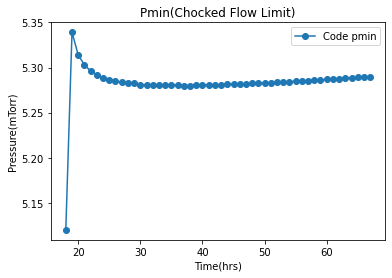

In [63]:
#Pmin (Chocked Flow) Calculation

#Load a,b,c parameters (these are the ones we will use for our model)
p_min_param=np.array([5.12,18.829,0])
print("Pmin Parameters:",p_min_param)
p_min_model=p_min_param[0]+p_min_param[1]*sr_kg+p_min_param[2]*sr_kg*sr_kg
plt.plot(cycle_time,p_min_model,marker="o",label="Code pmin")
plt.title("Pmin(Chocked Flow Limit)")
plt.xlabel("Time(hrs)")
plt.ylabel("Pressure(mTorr)")
plt.legend()

### Final Graphs Output

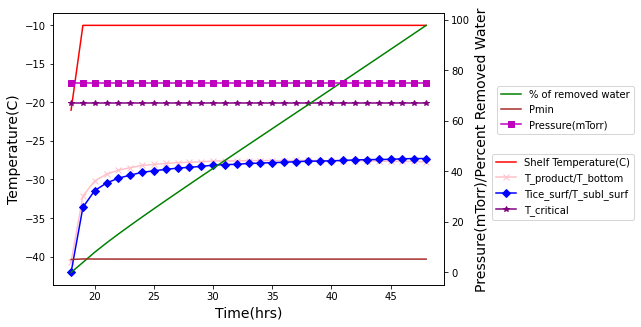

In [64]:
#Plot Final Graph For combined Pressures and Temperatures
pressure=75 #For LL Cycle
l=len(prw)
fig,ax = plt.subplots( figsize=(7,5) )
#Temperature axis
ax.plot(cycle_time[0:l],
        shelf_temp[0:l],
        color="red",label="Shelf Temperature(C)")
ax.plot(cycle_time[0:l],
        ols_fit()[0:l],
        color="pink",marker="x",label="T_product/T_bottom") #T_product/T_bottom
ax.plot(cycle_time[0:l],
        (param(ols_fit()))[1][0:l],
        color="blue",marker="D",label="Tice_surf/T_subl_surf") #Tice_surf/T_subl_surf
#Change this to real T critical
ax.plot(cycle_time[0:l],
        np.repeat(-20.1,cycle_time.shape[0])[0:l],
        color="purple",marker="*",label="T_critical") #Tcritical
ax.set_xlabel("Time(hrs)", fontsize = 14)
ax.set_ylabel("Temperature(C)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.5))

#Pressure Axis
ax2=ax.twinx()
ax2.plot(cycle_time[0:l],prw,color="green",label="% of removed water") #Percent Removed Water
ax2.plot(cycle_time[0:l],p_min_model[0:l],color="brown",label="Pmin") #pmin
ax2.plot(cycle_time[0:l],np.repeat(pressure,cycle_time.shape[0])[0:l],color="m",marker="s",label="Pressure(mTorr)") #pressure

ax2.set_ylabel("Pressure(mTorr)/Percent Removed Water", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.75))
plt.show()

# save the plot as a file
#fig.savefig('Final_Output1.jpg',format='jpeg')

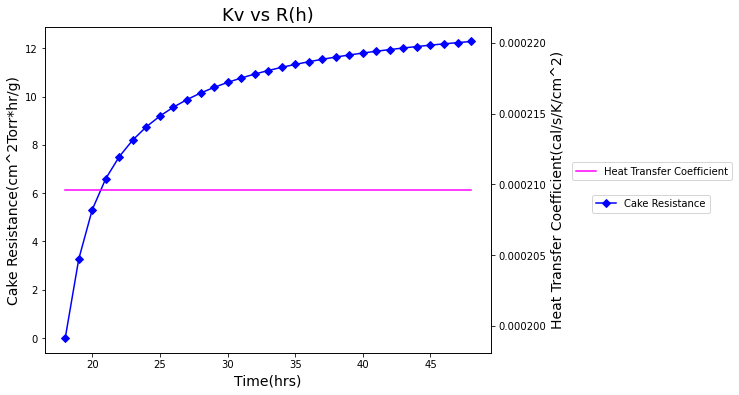

In [65]:
#Plot graph for Kv vs Rh
fig,ax = plt.subplots( figsize=(8,6) )
#Temperature axis
ax.plot(cycle_time[0:l],
        cake_res_model[0:l],
        color="blue",marker="D",label="Cake Resistance")
ax.set_xlabel("Time(hrs)", fontsize = 14)
ax.set_ylabel("Cake Resistance(cm^2Torr*hr/g)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.5,0.5))
ax2=ax.twinx()
ax2.plot(cycle_time[0:l],Kv_values[0:l],color="magenta",label="Heat Transfer Coefficient") #Percent Removed Water
ax2.set_ylabel("Heat Transfer Coefficient(cal/s/K/cm^2)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.55,0.6))
plt.title("Kv vs R(h)",fontsize=18)
plt.show()
# save the plot as a file
#fig.savefig('Final_Output2.jpg',format='jpeg')

In [66]:
#Extract Drying Time 

#Method 1: Using percent water removed
diff=[]
for i in range(len(prw)):
    if 100-prw[i]>0:
        diff.append(100-prw[i])
min_index=np.argmin(np.array(diff)) #Find index where percent of removed water is closest to 100
drying_time=cycle_time[min_index]
print("Drying Time:",drying_time,"(Hrs)")

# #Method 2: Using pirani and chamber pressure convergence
# drying_time_other=cycle_time[cycle_time.shape[0]-1] #Use stop index that indicated convergence of pressures
# print("Drying Time Using Pressure Convergence:",drying_time_other,"(Hrs)")

Drying Time: 48 (Hrs)


In [67]:
#Done